In [1]:
!pip install split-folders

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import splitfolders


# Display Data

In [3]:
df= pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
df.shape

(22424, 3)

In [5]:
import plotly.express as px

px.histogram(df , x="classname" ,  color="classname", title="Images By Categories ")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [7]:
mydata = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(mydata, output="mydata",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [02:35, 143.75 files/s]


In [8]:
train = '/kaggle/working/mydata/train'
val = '/kaggle/working/mydata/val'

In [9]:
import os
from PIL import Image

In [10]:
class_label= {'c0': 'Safe driving',
              'c1': 'Texting - right',
              'c2': 'Talking on the phone - right', 
              'c3': 'Texting - left', 
              'c4': 'Talking on the phone - left', 
              'c5': 'Operating the radio', 
              'c6': 'Drinking', 
              'c7': 'Reaching behind', 
              'c8': 'Hair and makeup', 
              'c9': 'Talking to passenger'}

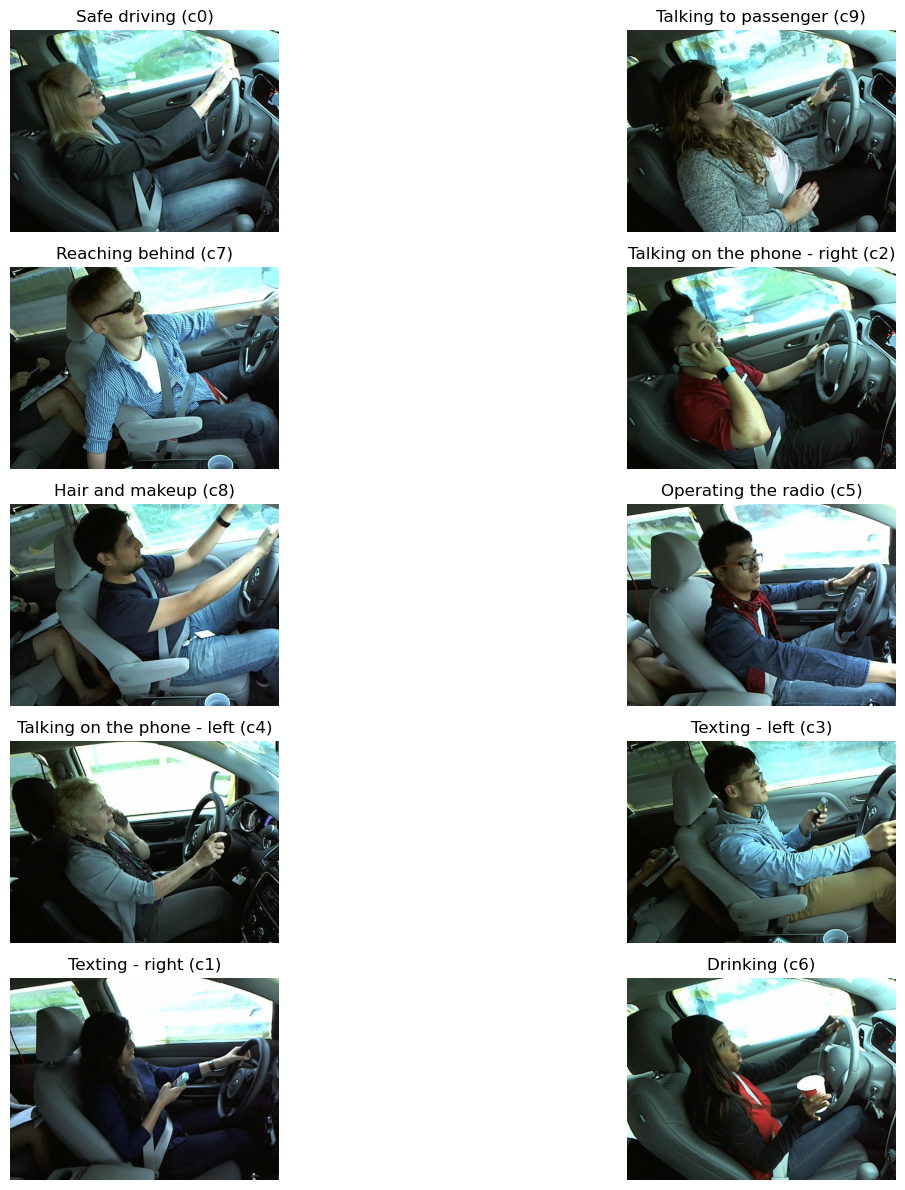

In [11]:
# fig, axs = plt.subplots(5, 2, figsize=(10,10))

subdirs = [subdir for subdir in os.listdir(train) if os.path.isdir(os.path.join(train, subdir))]

fig, axs = plt.subplots(5, 2, figsize=(16,12))

for i, subdir in enumerate(subdirs):
    file = os.listdir(os.path.join(train, subdir))[0]

    img = Image.open(os.path.join(train, subdir, file))
    axs[i//2, i%2].imshow(img)
    axs[i//2, i%2].set_title(f'{class_label[subdir]} ({subdir})')
    axs[i//2, i%2].axis('off')

plt.tight_layout()


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128

train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(256, 256),
        batch_size=128)

validation_generator = test_datagen.flow_from_directory(
        val,
        target_size=(256, 256),
        batch_size=128)
     

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


# CNN Model

In [13]:
from keras import layers
from keras import models

CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.MaxPooling2D((2, 2)))

CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Dropout(0.2))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.MaxPooling2D((2, 2)))

CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))

CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(512, activation='relu'))
CNN_model.add(layers.Dropout(0.3))
CNN_model.add(layers.Dense(128, activation='relu'))
CNN_model.add(layers.Dropout(0.2))
CNN_model.add(layers.Dense(10, activation='softmax'))

In [14]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                        

In [15]:
CNN_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
CNN_history=  CNN_model.fit(
              train_generator,
              epochs=15,
              batch_size=128,
              validation_data=validation_generator)


Epoch 1/15


2023-04-24 14:41:39.776642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 151s 998ms/step - loss: 1.7811 - accuracy: 0.3885 - val_loss: 16.5838 - val_accuracy: 0.0853
Epoch 2/15
141/141 [==============================] - 139s 995ms/step - loss: 0.2939 - accuracy: 0.9091 - val_loss: 27.8777 - val_accuracy: 0.0853
Epoch 3/15
141/141 [==============================] - 140s 992ms/step - loss: 0.1210 - accuracy: 0.9624 - val_loss: 11.7065 - val_accuracy: 0.2229
Epoch 4/15
141/141 [==============================] - 140s 990ms/step - loss: 0.0642 - accuracy: 0.9799 - val_loss: 0.6955 - val_accuracy: 0.8000
Epoch 5/15
141/141 [==============================] - 140s 992ms/step - loss: 0.0471 - accuracy: 0.9837 - val_loss: 0.0655 - val_accuracy: 0.9833
Epoch 6/15
141/141 [==============================] - 140s 989ms/step - loss: 0.0386 - accuracy: 0.9873 - val_loss: 0.0656 - val_accuracy: 0.9800
Epoch 7/15
141/141 [==============================] - 139s 989ms/step - loss: 0.0291 - accuracy: 0.9902 - val_loss: 0.0278 - val_acc

In [17]:
val_loss, val_acc = CNN_model.evaluate(validation_generator)
val_acc

36/36 [==============================] - 27s 743ms/step - loss: 0.0341 - accuracy: 0.9913


0.9913140535354614

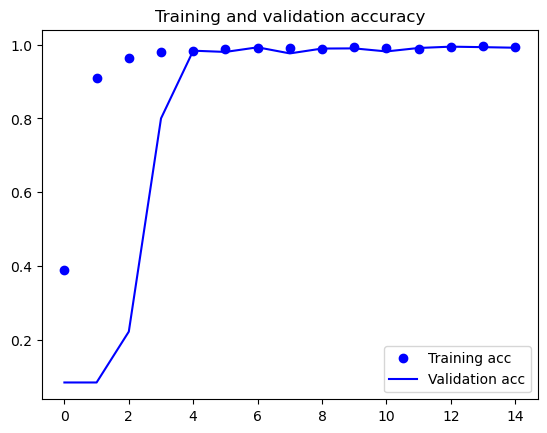

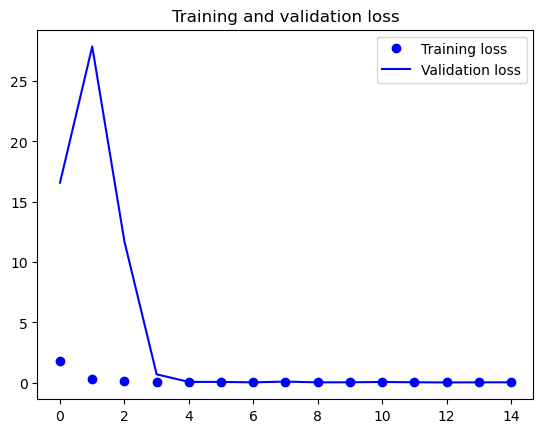

In [18]:
acc = CNN_history.history['accuracy']
val_acc = CNN_history.history['val_accuracy']
loss = CNN_history.history['loss']
val_loss = CNN_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
   fill_mode="nearest"
)
datagen_val = ImageDataGenerator(
    rescale=1./255)

In [20]:
train_generator = datagen.flow_from_directory(
        train,
        target_size=(256, 256),
        batch_size=128)

validation_generator = datagen_val.flow_from_directory(
        val,
        target_size=(256, 256),
        batch_size=128)




Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [21]:
from keras import layers
from keras import models

model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
model_aug.add(layers.MaxPooling2D((2, 2)))
#model_aug.add(layers.Dropout(0.5))

model_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2, 2)))
#model_aug.add(layers.Dropout(0.2))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Dropout(0.2))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(512, activation='relu'))
model_aug.add(layers.Dropout(0.3))
model_aug.add(layers.Dense(128, activation='relu'))
model_aug.add(layers.Dropout(0.2))
model_aug.add(layers.Dense(10, activation='softmax'))




In [22]:

model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
hist_aug=model_aug.fit(
      train_generator,
    batch_size=128,
     # steps_per_epoch=len(train)//128,
      epochs=15,
      validation_data=validation_generator)
      #validation_steps=len(val)//128)
    
    

Epoch 1/15


2023-04-24 15:17:37.329225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 347s 2s/step - loss: 1.8646 - accuracy: 0.3488 - val_loss: 7.9891 - val_accuracy: 0.1031
Epoch 2/15
141/141 [==============================] - 346s 2s/step - loss: 0.6006 - accuracy: 0.7914 - val_loss: 9.9821 - val_accuracy: 0.1889
Epoch 3/15
141/141 [==============================] - 354s 3s/step - loss: 0.2906 - accuracy: 0.9033 - val_loss: 2.5088 - val_accuracy: 0.4410
Epoch 4/15
141/141 [==============================] - 345s 2s/step - loss: 0.1966 - accuracy: 0.9376 - val_loss: 0.5455 - val_accuracy: 0.8372
Epoch 5/15
141/141 [==============================] - 346s 2s/step - loss: 0.1563 - accuracy: 0.9485 - val_loss: 0.0895 - val_accuracy: 0.9695
Epoch 6/15
141/141 [==============================] - 359s 3s/step - loss: 0.1277 - accuracy: 0.9585 - val_loss: 0.0601 - val_accuracy: 0.9826
Epoch 7/15
141/141 [==============================] - 347s 2s/step - loss: 0.1028 - accuracy: 0.9662 - val_loss: 0.0697 - val_accuracy: 0.9775
Epoch 8/15

In [24]:
val_loss, val_acc = model_aug.evaluate(validation_generator)
val_acc

36/36 [==============================] - 27s 742ms/step - loss: 0.0376 - accuracy: 0.9915


0.9915367364883423

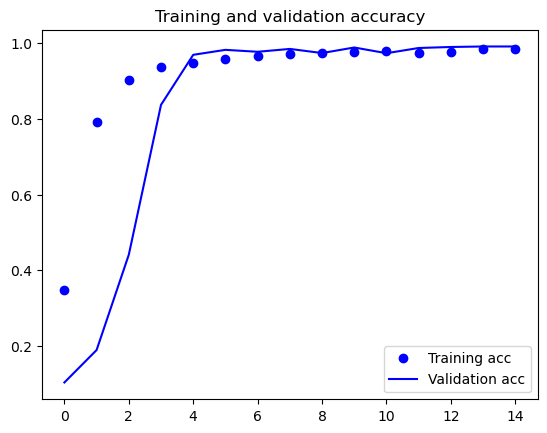

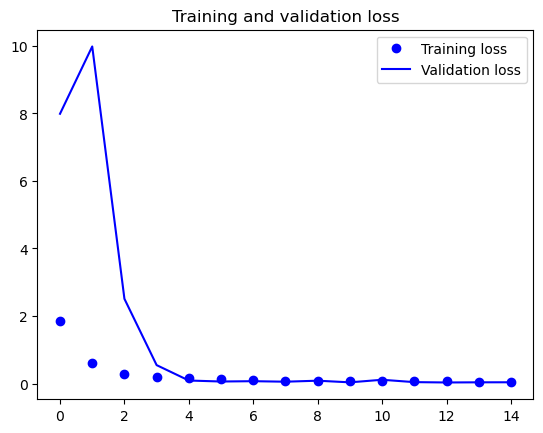

In [25]:
acc = hist_aug.history['accuracy']
val_acc = hist_aug.history['val_accuracy']
loss = hist_aug.history['loss']
val_loss = hist_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Transfer Learning VGG-16

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16

In [27]:
datagen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
   fill_mode="nearest",
    
)

datagen_test = ImageDataGenerator(
    preprocessing_function= preprocess_input
)



In [28]:
train_generator = datagen.flow_from_directory(
        train,
        target_size=(256, 256),
        batch_size=128)

validation_generator = datagen_test.flow_from_directory(
        val,
        target_size=(256, 256),
        batch_size=128)


Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [29]:
conv_VGG = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)


58889256/58889256 [==============================] - 0s 0us/step


In [30]:
conv_VGG.trainable = False

In [31]:
conv_VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [32]:
model_vgg = tf.keras.models.Sequential([
    conv_VGG,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [33]:
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [34]:
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
history_vgg=model_vgg.fit(
    train_generator,
    batch_size=128,
     # steps_per_epoch=len(train)//128,
      epochs=15,
      validation_data=validation_generator)



Epoch 1/15
141/141 [==============================] - 371s 3s/step - loss: 4.7817 - accuracy: 0.1579 - val_loss: 1.9922 - val_accuracy: 0.2523
Epoch 2/15
141/141 [==============================] - 362s 3s/step - loss: 1.6697 - accuracy: 0.4200 - val_loss: 0.7606 - val_accuracy: 0.7483
Epoch 3/15
141/141 [==============================] - 357s 3s/step - loss: 0.9812 - accuracy: 0.6749 - val_loss: 0.3001 - val_accuracy: 0.9020
Epoch 4/15
141/141 [==============================] - 358s 3s/step - loss: 0.6439 - accuracy: 0.7957 - val_loss: 0.1194 - val_accuracy: 0.9682
Epoch 5/15
141/141 [==============================] - 357s 3s/step - loss: 0.4194 - accuracy: 0.8741 - val_loss: 0.0934 - val_accuracy: 0.9746
Epoch 6/15
141/141 [==============================] - 357s 3s/step - loss: 0.3120 - accuracy: 0.9114 - val_loss: 0.0505 - val_accuracy: 0.9857
Epoch 7/15
141/141 [==============================] - 357s 3s/step - loss: 0.2359 - accuracy: 0.9335 - val_loss: 0.0370 - val_accuracy: 0.9904

In [36]:
val_loss, val_acc = model_vgg.evaluate(validation_generator)
val_acc

36/36 [==============================] - 33s 899ms/step - loss: 0.0265 - accuracy: 0.9931


0.9930957555770874

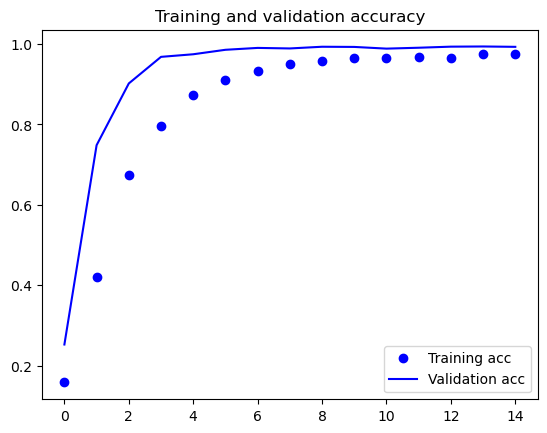

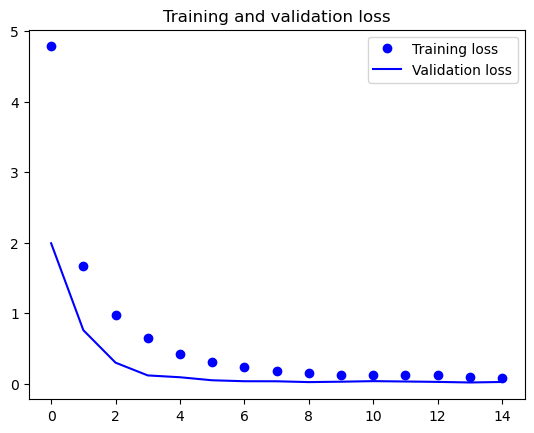

In [37]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# submission

In [38]:
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
test='/kaggle/input/state-farm-distracted-driver-detection/imgs/.'

testData = datagen_test.flow_from_directory(test,
                                            shuffle=False,
                                            target_size=(256, 256),
                                            batch_size = 128,
                                            classes=['test'])

predict_test = model_vgg.predict(testData)


Found 79726 images belonging to 1 classes.
623/623 [==============================] - 1218s 2s/step


In [39]:
base_dir = '../input/state-farm-distracted-driver-detection'
test_dir = os.path.join(base_dir, 'imgs')

In [40]:
test=os.path.join(base_dir, "imgs/test")
test_ids = sorted(os.listdir(test))
sub_df = pd.DataFrame(columns = ['img','c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

for i in range(len(predict_test)):
    sub_df.loc[i, 'img'] = test_ids[i]
    sub_df.loc[i, 'c0':'c9'] = predict_test[i]
    
sub_df.to_csv("/kaggle/working/submission.csv",index=False)

In [41]:
sub_df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,img_10.jpg,0.77123,0.000799,0.001989,0.016109,0.015066,0.070577,0.001442,0.000132,0.015315,0.107342
2,img_100.jpg,0.999091,0.0,0.0,0.000027,0.000018,0.000027,0.0,0.0,0.000021,0.000816
3,img_1000.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,img_100000.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
